ImportaciÃ³n de librerÃ­as necesarias

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
from scipy import stats

1. Cargar y preparar los datos

In [30]:
data = pd.read_csv("Ventas_Bebidas_Demo.csv", encoding='ISO-8859-1')

Convertimos la columna 'FECHA' al tipo datetime para trabajar con fechas

In [31]:
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d-%m-%y')

Agrupamos las ventas por TIENDA y FECHA, sumando los montos diarios

In [32]:
ventas_agrupadas = data.groupby(['TIENDA', 'FECHA'])['MONTO'].sum().reset_index()

Seleccionar la tienda con mayor nÃºmero de transacciones

In [33]:
tienda_top = ventas_agrupadas['TIENDA'].value_counts().idxmax()
serie_tienda = ventas_agrupadas[ventas_agrupadas['TIENDA'] == tienda_top]

Crear la serie temporal diaria con Ã­ndice de fechas y rellenar valores faltantes con 0

In [34]:
serie_tienda = serie_tienda.set_index('FECHA').asfreq('D').fillna(0)

2. Aplicar Triple Exponential Smoothing (TES)<br>
TES descompone la serie temporal en tendencia, estacionalidad y ciclo

In [35]:
model_tes = ExponentialSmoothing(
    serie_tienda['MONTO'], trend='add', seasonal='add', seasonal_periods=365
).fit()

c:\Users\ingjo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


PronÃ³stico de ventas para los prÃ³ximos 30 dÃ­as

In [36]:
forecast_tes = model_tes.forecast(30)

Calcular el MAPE (Error Absoluto Porcentual Medio) para evaluar el modelo

In [37]:
mape_tes = mean_absolute_percentage_error(serie_tienda['MONTO'], model_tes.fittedvalues)

Graficar el ajuste y el pronÃ³stico del modelo TES

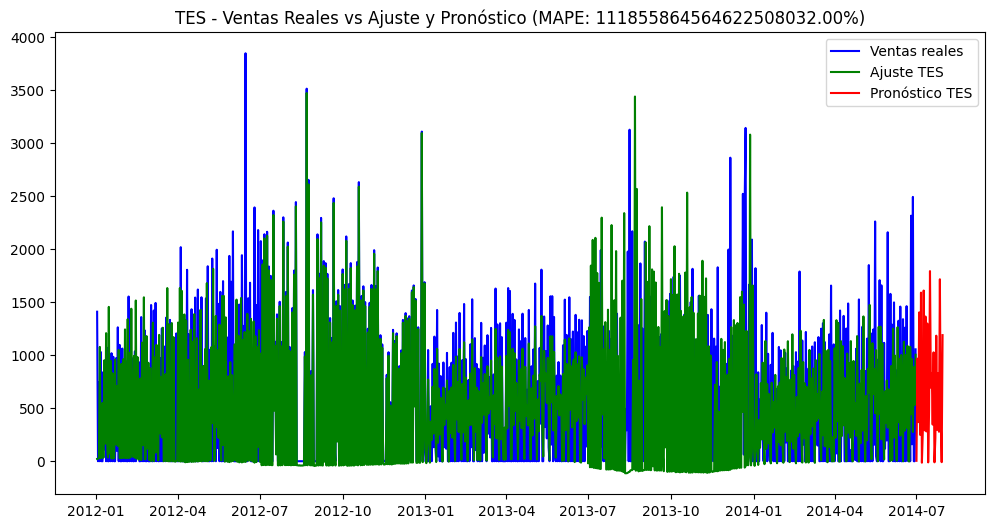

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(serie_tienda['MONTO'], label='Ventas reales', color='blue')
plt.plot(model_tes.fittedvalues, label='Ajuste TES', color='green')
plt.plot(forecast_tes, label='Pronóstico TES', color='red')
plt.legend(loc='best')
plt.title(f'TES - Ventas Reales vs Ajuste y Pronóstico (MAPE: {mape_tes:.2%})')
plt.show()

3. DescomposiciÃ³n de la serie temporal<br>
La descomposiciÃ³n muestra la tendencia, estacionalidad y los residuos

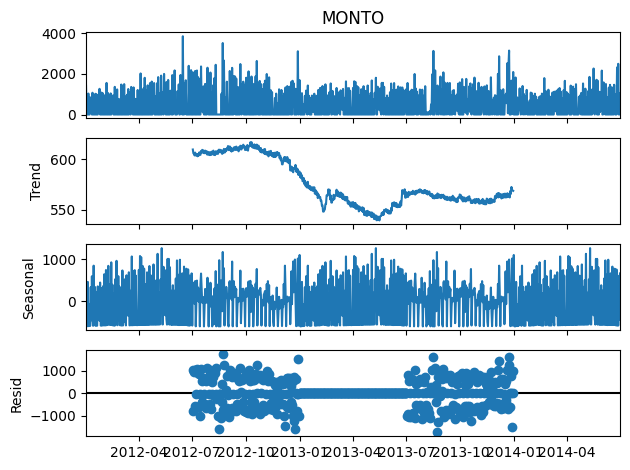

In [39]:
decomposition = seasonal_decompose(serie_tienda['MONTO'], model='additive', period=365)
decomposition.plot()
plt.show()

4. Ajustar el modelo ARIMA<br>
ACF y PACF nos ayudan a seleccionar los parÃ¡metros p, d y q del modelo ARIMA

In [40]:
lag_acf = acf(serie_tienda['MONTO'], nlags=20)
lag_pacf = pacf(serie_tienda['MONTO'], nlags=20)

Graficar ACF y PACF para identificar los parÃ¡metros

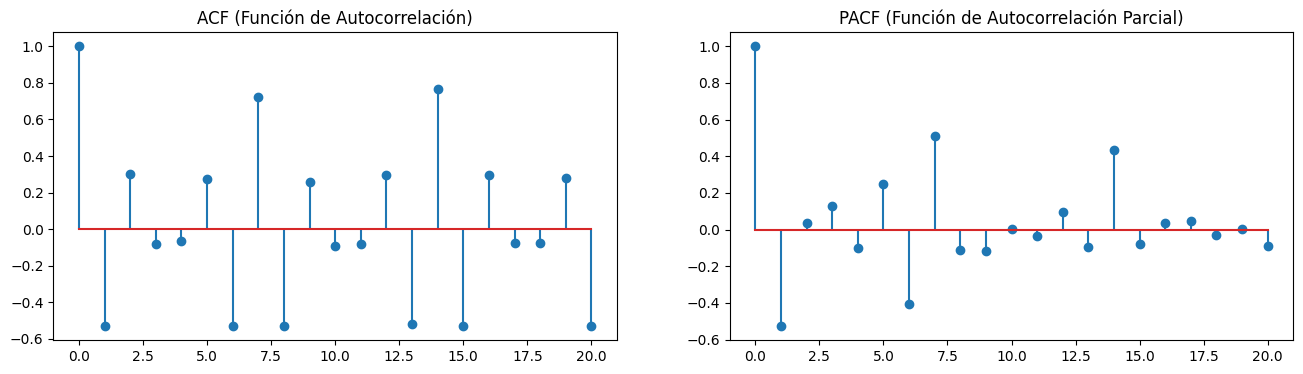

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].stem(lag_acf)
axes[0].set_title('ACF (Función de Autocorrelación)')
axes[1].stem(lag_pacf)
axes[1].set_title('PACF (Función de Autocorrelación Parcial)')
plt.show()

Ajustar el modelo ARIMA con los parÃ¡metros p=1, d=1, q=1

In [42]:
model_arima = ARIMA(serie_tienda['MONTO'], order=(1, 1, 1)).fit()
forecast_arima = model_arima.forecast(30)

Graficar el ajuste y el pronÃ³stico del modelo ARIMA

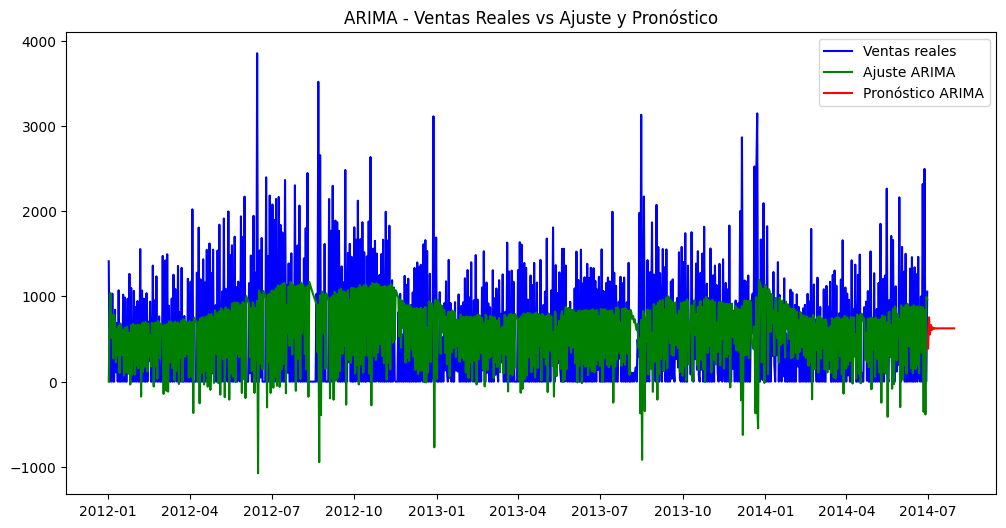

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(serie_tienda['MONTO'], label='Ventas reales', color='blue')
plt.plot(model_arima.fittedvalues, label='Ajuste ARIMA', color='green')
plt.plot(forecast_arima, label='Pronóstico ARIMA', color='red')
plt.legend(loc='best')
plt.title('ARIMA - Ventas Reales vs Ajuste y Pronóstico')
plt.show()

5. Prueba de Ruido Blanco (ADF Test)<br>
La prueba ADF verifica si la serie es estacionaria

In [44]:
adf_result = adfuller(serie_tienda['MONTO'])
print(f'Estadístico ADF: {adf_result[0]}')
print(f'Valor p: {adf_result[1]}')

Estadístico ADF: -4.362559046608019
Valor p: 0.0003455477985451685


In [45]:
if adf_result[1] < 0.05:
    print("La serie es estacionaria (rechazamos la hipótesis nula).")
else:
    print("La serie no es estacionaria (no rechazamos la hipótesis nula).")

La serie es estacionaria (rechazamos la hipótesis nula).


6. DetecciÃ³n de Valores AtÃ­picos (Outliers)<br>
Usamos el z-score para detectar outliers (valores fuera de Â±3 desviaciones estÃ¡ndar)

In [46]:
z_scores = np.abs(stats.zscore(serie_tienda['MONTO']))
outliers = serie_tienda[z_scores > 3]

Mostrar los valores atÃ­picos detectados

In [47]:
print("Valores Atí­picos Detectados:")
print(outliers)

Valores Atí­picos Detectados:
                  TIENDA    MONTO
FECHA                            
2012-06-15  1.000051e+09  3850.27
2012-08-22  1.000051e+09  3516.00
2012-12-28  1.000051e+09  3111.06
2013-08-16  1.000051e+09  3128.96
2013-12-06  1.000051e+09  2864.77
2013-12-23  1.000051e+09  3145.52
